(counterfactuals_do_operator)=
# Counterfactual generation using pymc do-operator

:::{post} August, 2023
:tags: causality, causal inference, do-operator, counterfactuals
:category: beginner, reference
:author: Shekhar Khandelwal
:::

In [1]:
import warnings

import arviz.preview as az
import numpy as np
import pandas as pd
import pymc as pm

warnings.filterwarnings("ignore")

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-variat")
rng = np.random.default_rng(42)
SEED = 8927

# Introduction

In the realm of data science and analytics, understanding the causal relationships between variables is paramount. While traditional statistical methods have provided insights into these relationships, the advent of probabilistic programming has ushered in a new era of causal analysis. In this article, we will explore the power of counterfactuals in causal analysis using the PyMC framework, with a special focus on the “do-operator.”
Counterfactuals are essentially “what-if” scenarios that allow us to understand the potential outcomes had a different action been taken or a different condition been present. By leveraging the PyMC framework and its “do-operator,” we can programmatically simulate these scenarios, giving us a deeper understanding of the relationships between predictors and target variables.

Through a step-by-step guide, we will delve into the process of building a PyMC model skeleton, generating data using the do-operator, and validating the relationships captured by the model. Furthermore, we will explore the magic of the do-operator in simulating different ‘what-if’ scenarios, akin to programmatic A/B testing.

- Step 1. Build a pymc model skeleton
- Step 2. Use model skeleton and generate data using do-operator to infuse relationship between predictors and target variable (ssshhh, that’s a hidden superhero feature of do-operator ;) )
- Step 3. Use observe-operator to assign generated data on the model skeleton
- Step 4. Create samples and validate that the infused relationship between predictors and target variable are captured by the model samples (isn’t that what we expect a predictive model to do ;) )
- Step 5. Use do-operator to time travel, and generate target variable with different ‘what-if’ scenarios (basically mimic A/B testing…programatically)


### Step 1. Build a pymc model skeleton

For this demo, we are building a very simple Linear Regression model.
- Predictor — ‘a’, ‘b’, ‘c’
- Target Variable — ‘y’
- Coefficients —
>- ‘beta_ay’ -> coefficient of |a|
>- ‘beta_by’ -> coefficient of |b|
>- ‘beta_cy’ -> coefficient of |c|

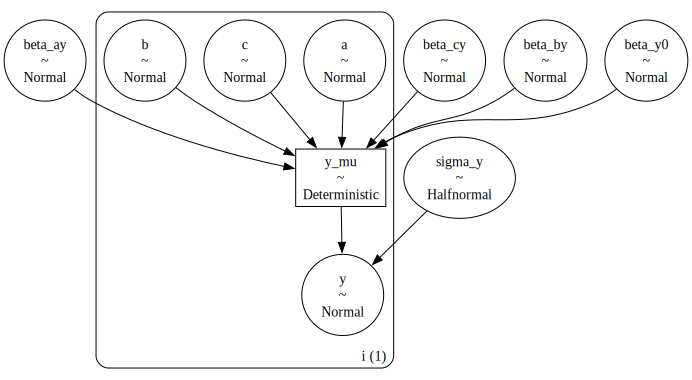

In [3]:
with pm.Model(coords={"i": [0]}) as model_generative:
    # priors
    beta_y0 = pm.Normal("beta_y0")
    beta_ay = pm.Normal("beta_ay")
    beta_by = pm.Normal("beta_by")
    beta_cy = pm.Normal("beta_cy")
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    a = pm.Normal("a", mu=0, sigma=1, dims="i")
    b = pm.Normal("b", mu=0, sigma=1, dims="i")
    c = pm.Normal("c", mu=0, sigma=1, dims="i")
    y_mu = pm.Deterministic(
        "y_mu", beta_y0 + (beta_ay * a) + (beta_by * b) + (beta_cy * c), dims="i"
    )
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")


pm.model_to_graphviz(model_generative)

### Step 2. Use model skeleton and generate data using do-operator to infuse relationship between predictors and target variable. We will use this generated data for modelling later.

Let’s first define the predictors relationship with target variable.

In [4]:
true_values = {"beta_ay": 1.5, "beta_by": 0.7, "beta_cy": 0.3, "sigma_y": 0.2, "beta_y0": 0.0}

Basically what we are saying here is, we are intentionally defining the coefficient values, which we expect predictive model to predict later on.

Now the magic begins. We will use do-operator to use this dictionary and sample data variables. How do we do this ? Simple by passing two arguments to pymc do-operator. First, the model skeleton object. And second, the coefficient dictionary.

In [5]:
model_simulate = pm.do(model_generative, true_values)

This will create a new model object with the coefficent variables values infused. 

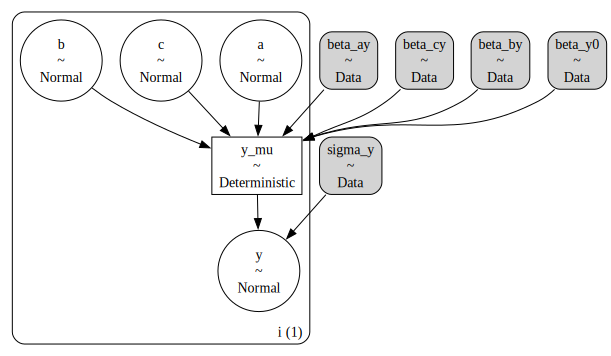

In [6]:
model_simulate.to_graphviz()

The gray shades on the coefficient variables depicts the tale. Check the previous model graph, it was all white.

Now, all we have to do is generate samples, the known pymc way.

Lets generate 100 samples.

In [7]:
N = 100

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N)

Sampling: [a, b, c, y]


We know that this generates an Arviz object, and since we have called sample_prior_predictive, hence the object will only contain priors.

In [8]:
simulate

Inference data with groups:
	> prior
	> constant_data

Extract the sampled prior data into a pandas dataframe.

In [9]:
observed = {
    "a": simulate.prior["a"].values.flatten(),
    "b": simulate.prior["b"].values.flatten(),
    "c": simulate.prior["c"].values.flatten(),
    "y": simulate.prior["y"].values.flatten(),
}

df = pd.DataFrame(observed)
print(df.shape)
df.head(5)

(100, 4)


,a,b,c,y
0,0.168609,0.965789,-1.583881,0.615137
1,-0.654816,0.045357,-1.119634,-1.397617
2,0.330262,0.955123,-0.115252,0.939636
3,-0.919746,-0.629055,1.350298,-1.482930
4,-0.527499,0.046205,-0.387889,-1.003153


Ok, so now we are all set with a sample data.

### Step 3. Use observe-operator to assign generated data on the model skeleton

Now, this is another cool feature of pymc newly introduced observe method. Observe method, takes in a model skeleton and the dictionary with the data for the variables we want to infuse into the model.

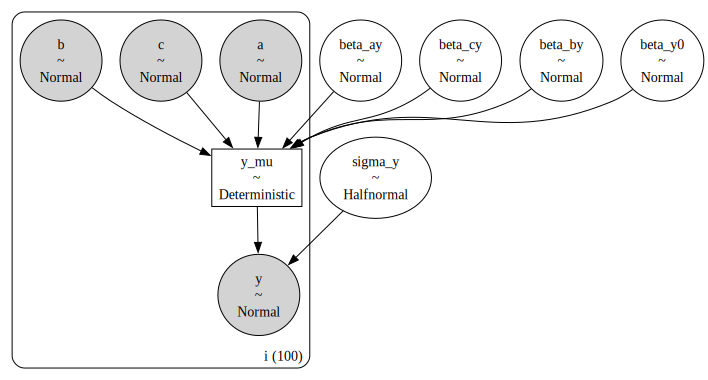

In [10]:
data_dict = {"a": df["a"], "b": df["b"], "c": df["c"], "y": df["y"]}
model_inference = pm.observe(model_generative, data_dict)
model_inference.set_dim("i", N, coord_values=np.arange(N))
pm.model_to_graphviz(model_inference)

See the gray matter again. This time we have observed data infused into the model, and we have to sample for the coefficient and other parameters.

So, lets sample.

### Step 4. Create samples and validate that the infused relationship between predictors and target variable are captured by the model samples

In [11]:
with model_inference:
    idata = pm.sample(random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_cy, beta_by, beta_ay, beta_y0, sigma_y]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Now, lets validate if model captured the infused coefficient values in the data.

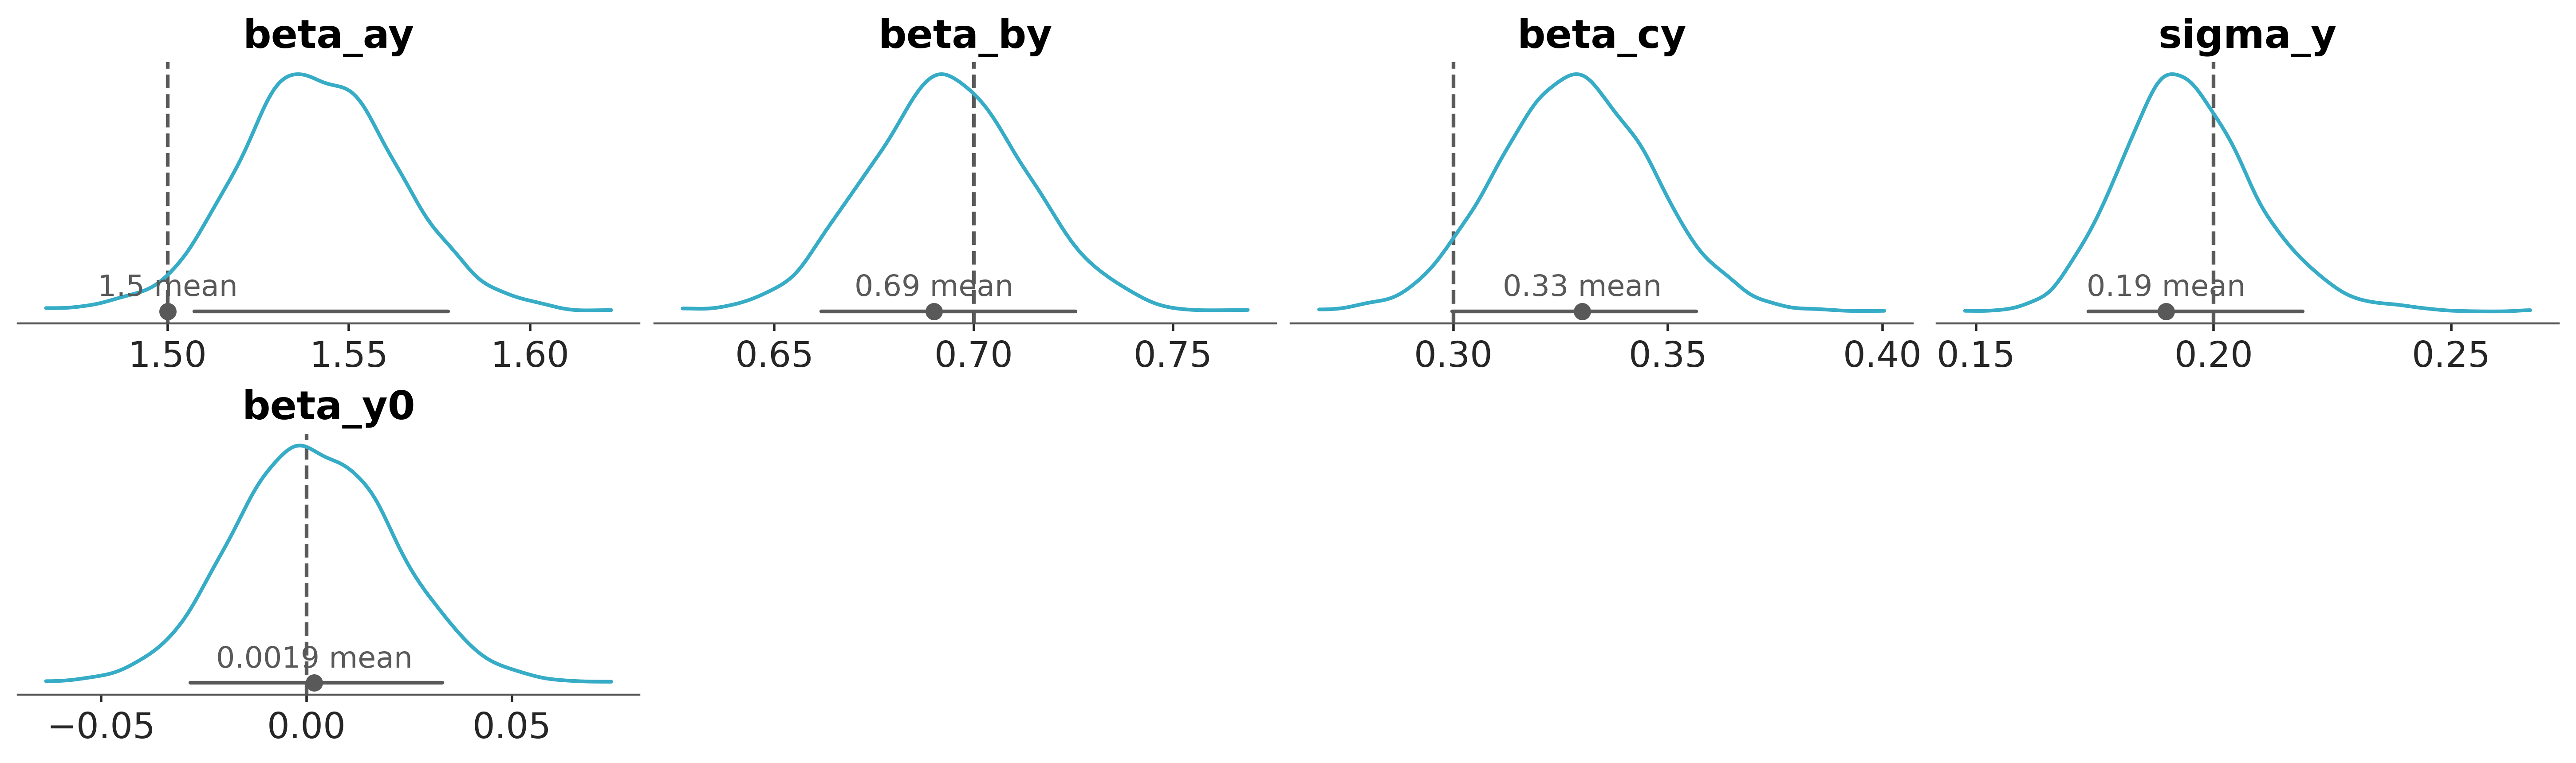

In [12]:
pc = az.plot_dist(
    idata,
    var_names=list(true_values.keys()),
)
az.add_lines(pc, true_values);

BAM ! Pretty nice fit !

Now, lets do what we are supposed to do ! Counterfactuals.

Basically, this is about generating target variable values with different predictor values. Basically, answering what if questions !

_What-if there was all ‘b’ values as 0 ?_

_What-if all ‘b’ values were double ?_

How to do this ? Here you go..

### Step 5. Use do-operator to time travel, and generate target variable with different ‘what-if’ scenarios.
Since, we want to experiment with ‘b’, lets first assign observed values to ‘a’ and ‘c’. Not to ‘y’, because that’s what we want to sample. Correct !

In [13]:
model_counterfactual = pm.do(model_inference, {"a": df["a"], "c": df["c"]})

Now, lets begin the fun part. Let’s generate counterfactuals.

### _Scenario 1 :- What if all values for ‘b’ were 0 ?_

In [14]:
model_b0 = pm.do(model_counterfactual, {"b": np.zeros(N, dtype="int32")}, prune_vars=True)
model_b1 = pm.do(model_counterfactual, {"b": df["b"]}, prune_vars=True)

Just sample.

In [15]:
# Sample when 'b' was 0: P(y | (a,c), do(b=0))
idata_b0 = pm.sample_posterior_predictive(
    idata,
    model=model_b0,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)
# Sample when 'b' was as observed: P(y | (a,c), do(b=observed))
idata_b1 = pm.sample_posterior_predictive(
    idata,
    model=model_b1,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)

Sampling: []


Output()

Sampling: []


Output()

Some basic python and here we have the counterfactuals.

In [16]:
df["b_scenario_1"] = 0
df["y_scenario_1"] = (
    idata_b0.predictions.y_mu.mean(("chain", "draw")).values.reshape(1, -1).flatten()
)
df.head(5)

,a,b,c,y,b_scenario_1,y_scenario_1
0,0.168609,0.965789,-1.583881,0.615137,0,-0.257788
1,-0.654816,0.045357,-1.119634,-1.397617,0,-1.374868
2,0.330262,0.955123,-0.115252,0.939636,0,0.473174
3,-0.919746,-0.629055,1.350298,-1.482930,0,-0.973051
4,-0.527499,0.046205,-0.387889,-1.003153,0,-0.938561


### _Scenario 2: What if ‘b’ was 5 times as observed_

In [17]:
model_b0 = pm.do(model_counterfactual, {"b": 5 * df["b"]}, prune_vars=True)
model_b1 = pm.do(model_counterfactual, {"b": df["b"]}, prune_vars=True)

Sample.

In [18]:
# Sample when 'b' was 5 times b: P(y | (a,c), do(b=5*b))
idata_b0 = pm.sample_posterior_predictive(
    idata,
    model=model_b0,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)
# Sample when 'b' was as observed: P(y | (a,c), do(b=observed))
idata_b1 = pm.sample_posterior_predictive(
    idata,
    model=model_b1,
    predictions=True,
    var_names=["y_mu"],
    random_seed=SEED,
)

df["b_scenario_2"] = 5 * df["b"]
df["y_scenario_2"] = (
    idata_b0.predictions.y_mu.mean(("chain", "draw")).values.reshape(1, -1).flatten()
)
df.head(5)

Sampling: []


Output()

Sampling: []


Output()

,a,b,c,y,b_scenario_1,y_scenario_1,b_scenario_2,y_scenario_2
0,0.168609,0.965789,-1.583881,0.615137,0,-0.257788,4.828943,3.090282
1,-0.654816,0.045357,-1.119634,-1.397617,0,-1.374868,0.226784,-1.217631
2,0.330262,0.955123,-0.115252,0.939636,0,0.473174,4.775613,3.784268
3,-0.919746,-0.629055,1.350298,-1.482930,0,-0.973051,-3.145274,-3.153777
4,-0.527499,0.046205,-0.387889,-1.003153,0,-0.938561,0.231026,-0.778383


Ok, so now you got the idea. It's an open playground. Go back in time, change whatever you want to change, and see how output changes.

This opens the door for many more possibilities in various use cases. Especially, Causal Analytics !

## Authors
- Authored by [Shekhar Khandelwal](https://github.com/shekharkhandelwal1983) in August 2023
- Updated by Osvaldo Martin in February 2026 

## References

https://medium.com/@khandelwal-shekhar/counterfactuals-for-causal-analysis-via-pymc-do-operator-234ba04e4e80

https://www.pymc-labs.io/blog-posts/causal-analysis-with-pymc-answering-what-if-with-the-new-do-operator/

## Watermark

In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Thu, 12 Feb 2026

Python implementation: CPython
Python version       : 3.13.11
IPython version      : 8.29.0

pytensor: 2.37.0

arviz : 0.23.1
numpy : 2.2.6
pandas: 2.2.3
pymc  : 5.27.1

Watermark: 2.6.0



:::{include} ../page_footer.md
:::